<a href="https://colab.research.google.com/github/shivendr7/SatGAN/blob/master/EEGAN_4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

250257408/250242400 [==============================] - 106s 0us/step


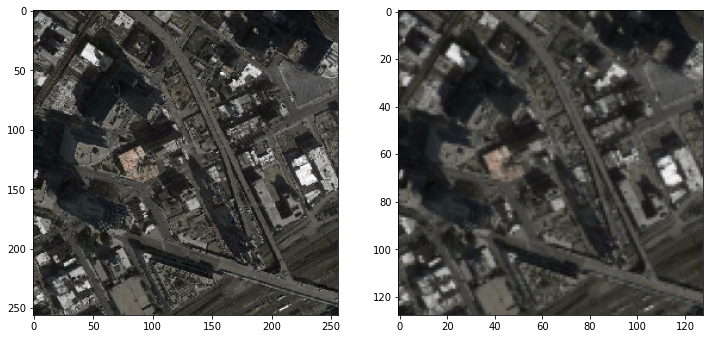

In [2]:
import os
import matplotlib.pyplot as plt
from os import listdir
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.utils import get_file
from tensorflow.io import read_file
from skimage import data, color
from skimage.transform import resize
url='http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz'
path_to_zip=get_file('maps.tar.gz', origin=url, extract=True)
inside_train=listdir('/root/.keras/datasets/maps/train')
src_list=[]
full_path='/root/.keras/datasets/maps/train/'
for filename in inside_train:
  pixels=load_img(full_path+filename, target_size=(256,512))
  pixels=img_to_array(pixels)
  src_list.append(pixels[:,:256])
src_list=np.asarray(src_list)
resized_list=[]
for i in src_list:
  image=i
  image_resized = resize(image, (image.shape[0] // 2, image.shape[1] // 2),
                        anti_aliasing=True)
  resized_list.append(image_resized)
resized_list=np.array(resized_list)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(src_list[0].astype('uint8'))
plt.subplot(1,2,2)
plt.imshow(resized_list[0].astype('uint8'))

In [3]:
resized_list=(resized_list-127.5)/127.5
src_list=(src_list-127.5)/127.5

In [4]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Concatenate, Lambda, Subtract, Add, Activation, Reshape, Multiply, Flatten, Dropout, Dense, BatchNormalization, Permute
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from tensorflow.keras.initializers import RandomNormal, Ones
import tensorflow as tf
from keras.losses import MeanSquaredError, MeanAbsolutePercentageError
import keras.backend as K
import numpy as np
from keras.models import model_from_json 

In [5]:
def dense_block(in_layer):
  init=RandomNormal(stddev=0.2)
  conv1=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(in_layer)
  conv11=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv1)
  conv12=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv1)
  conv13=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv1)
  concat1=Concatenate()([conv11, conv12, conv13])
  conv201=Concatenate()([concat1, conv11])
  conv202=Concatenate()([concat1, conv12])
  conv203=Concatenate()([concat1, conv13])
  conv21i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv201)
  conv22i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv202)
  conv23i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv203)
  conv21=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv21i)
  conv22=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv22i)
  conv23=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv23i)
  concat2=Concatenate()([conv21, conv22, conv23])
  conv301=Concatenate()([concat2, conv21i])
  conv302=Concatenate()([concat2, conv22i])
  conv303=Concatenate()([concat2, conv23i])
  conv31i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv301)
  conv32i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv302)
  conv33i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv303)
  conv31=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv31i)
  conv32=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv32i)
  conv33=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv33i)
  concat3=Concatenate()([conv31, conv32, conv33])
  conv401=Concatenate()([concat3, conv31i])
  conv402=Concatenate()([concat3, conv32i])
  conv403=Concatenate()([concat3, conv33i])
  conv41i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv401)
  conv42i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv402)
  conv43i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv403)
  concat4=Concatenate()([conv41i, conv42i, conv43i])
  out_layer=Concatenate()([concat4, conv1])
  return out_layer

In [8]:
def SubpixelConv2D(input_shape, scale=4):
    """
    Keras layer to do subpixel convolution.
    NOTE: Tensorflow backend only. Uses tf.depth_to_space
    Ref:
        [1] Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network
            Shi et Al.
            https://arxiv.org/abs/1609.05158
    :param input_shape: tensor shape, (batch, height, width, channel)
    :param scale: upsampling scale. Default=4
    :return:
    """
    # upsample using depth_to_space
    def subpixel_shape(input_shape):
        dims = [input_shape[0],
                input_shape[1] * scale,
                input_shape[2] * scale,
                int(input_shape[3] / (scale ** 2))]
        output_shape = tuple(dims)
        return output_shape

    def subpixel(x):
        return tf.nn.depth_to_space(x, scale)

    return Lambda(subpixel, output_shape=subpixel_shape, name='subpixel')

In [9]:
def build_udsn(image_shape):
  inp=Input(shape=image_shape)
  db1=dense_block(inp)
  con=Concatenate()([db1, db1])
  db2=dense_block(con)
  con=Concatenate()([db1, db2, db2])
  db3=dense_block(con)
  con=Concatenate()([db1, db2, db3, db3])
  db4=dense_block(con)
  con=Concatenate()([db1, db2, db3, db4, db4])
  db5=dense_block(con)
  con=Concatenate()([db1, db2, db3, db4, db5, db5])
  db6=dense_block(con)
  sub_net=Conv2D(filters=64, kernel_size=(4,4), padding='same', activation='relu', kernel_initializer='he_uniform')(db6)
  sub_net=Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  sub_net=Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  LR=Conv2D(filters=12, kernel_size=(3,3), padding='same')(sub_net)
  LR=LeakyReLU(alpha=0.02)(LR)
  Ibase=SubpixelConv2D(LR.shape, scale=2)(LR)
  Ibase=BatchNormalization(momentum=0.8)(Ibase)
  Ibase=Activation('tanh')(Ibase)
  model=Model(inputs=inp, outputs=Ibase)
  return model

In [10]:
#eesn essentials
def meanfilter(shape, dtype=None):   #kernel to find mean of 3-channel pixel data
  f=np.array([
              [[[.3333],
                [.3333],
                [.33333]]]
  ])
  return K.variable(f, dtype='float32')
def laplacian(shape, dtype=None):   #laplacian kernel
  f=np.array([
      [[[-1]],[[-1]],[[-1]]],
      [[[-1]],[[ 8]],[[-1]]],
      [[[-1]],[[-1]],[[-1]]]
  ])
  return K.variable(f, dtype='float32')
def channel_thrice(shape, dtype=None):   #kernel to triplicate the single channel data
  f=np.array([
              [[[1, 1, 1]]]   #3 for three layers of filters
  ])
  return K.variable(f, dtype='float32')

In [11]:
def build_eesn(Ibase_shape):
  inp=Input(shape=(Ibase_shape))
  bw=Conv2D(filters=1, kernel_size=(1,1), padding='same', kernel_initializer=meanfilter, trainable=False)(inp)  #no change recommended   
  Iedge=Conv2D(filters=1, kernel_size=(3,3), padding='same', kernel_initializer=laplacian, trainable=False)(bw)     #no change recommended
  Itrip=Conv2D(filters=3, kernel_size=(1,1), padding='same', kernel_initializer=channel_thrice, trainable=False)(Iedge)   #no change recommended
  
  sub=Subtract()([inp, Itrip])
  ee=Conv2D(filters=32, kernel_size=(3,3), padding='same', strides=(2,2))(Iedge)
  ee=Conv2D(filters=64, kernel_size=(3,3), padding='same')(ee)
  ee=Conv2D(filters=16, kernel_size=(1,1), padding='same')(ee)
  
  #dense net
  db=dense_block(ee)
  db=dense_block(db)
  db=dense_block(db)
  db=Conv2D(16, kernel_size=(3,3), padding='same')(db)

  #mask branch
  mb=Conv2D(filters=16, kernel_size=(3,3), padding='same')(ee)
  mb=LeakyReLU(alpha=0.02)(mb)
  mb=Conv2D(filters=32, kernel_size=(3,3), padding='same')(mb)
  mb=LeakyReLU(alpha=0.02)(mb)
  mb=Conv2D(filters=16, kernel_size=(3,3), padding='same')(mb)
  mb=LeakyReLU(alpha=0.02)(mb)
  mb=Activation('sigmoid')(mb)

  #transpose=Permute((2,1,3), input_shape=db.shape)(db)
  product=Multiply()([db, mb])  #multiplies element wise
  #con=Concatenate()([mb, db])
  #transpose2=Permute((2,1,3), input_shape=product.shape)(product)
  sub_net=Conv2D(filters=64, kernel_size=(4,4), padding='same', activation='relu', kernel_initializer='he_uniform')(product)
  sub_net=Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  sub_net=Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  ee=Conv2D(4, kernel_size=(3,3), padding='same')(sub_net)
  Istedge=SubpixelConv2D(ee.shape, scale=2)(ee)
  #Istedge=Conv2D(1, kernel_size=(3,3), padding='same')(Istedge)
  Istedge=Conv2D(filters=3, kernel_size=(1,1), padding='same', kernel_initializer=channel_thrice, trainable=False)(Istedge)  #no change recommended
  
  #Istedge=BatchNormalization()(Istedge)
  SR=Add()([Istedge, sub])
  SR=BatchNormalization()(SR)
  SR=Activation('tanh')(SR)
  
  model=Model(inputs=inp, outputs=SR)
  return model

In [12]:
def consistency_loss(y_true, y_pred):
  lambd=5
  return charbonnier_penalty(y_true, y_pred)

mape=MeanAbsolutePercentageError()
def consistency_model(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  ISR=eesn(Ibase)
  model=Model(inputs=inp, outputs=ISR)
  opt=Adam(learning_rate=0.00002, beta_1=0.5)
  model.compile(loss='mse', optimizer=opt)
  return model

In [13]:
from keras.applications.vgg16 import VGG16
vgg=VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg.trainable=False
#resize_layer=Conv2D(filters=3, kernel_size=(33,33), kernel_initializer=Ones(), trainable=False)

58900480/58889256 [==============================] - 1s 0us/step


In [14]:
def charbonnier_penalty(y_true, y_pred):
  epsilon=0.001 #compensation parameter
  return K.mean(Subtract()([y_true, y_pred])**2 + epsilon**2)
  #return K.mean(K.square(y_true- y_pred) + epsilon**2)

def charbonnier_model(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  #resize_Ibase=resize_layer(Ibase)
  out=vgg(Ibase*127.5+127.5)
  model=Model(inputs=inp, outputs=out)
  opt=Adam(learning_rate=0.00002, beta_1=0.5, clipnorm=1)
  model.compile(loss='mse', optimizer=opt)
  return model

In [15]:
def build_discriminator(img_shape):
  def block(Input, k, n, s):
    l1=Conv2D(n, kernel_size=(k,k), strides=(s,s), padding='same')(Input)
    Bn=BatchNormalization()(l1)
    Lrlu=LeakyReLU(alpha=0.02)(Bn)
    return Lrlu
  I1=Input(shape=img_shape)
  c1=Conv2D(64, kernel_size=(3,3), padding='same')(I1)
  l1=LeakyReLU(alpha=0.02)(c1)
  b1=block(l1, 3, 64, 2)
  b2=block(b1, 3, 128, 1)
  b3=block(b2, 3, 128,2)
  b4=block(b3, 3, 256, 1)
  b5=block(b4, 3, 256, 2)
  b6=block(b5, 3, 512, 1)
  b7=block(b6, 3, 512, 2)
  b8=Flatten()(b7)
  b9=Dropout(.5)(b8)
  l8=Dense(1024)(b9)
  b10=Dropout(.25)(l8)
  l9=LeakyReLU(alpha=0.02)(b10)
  l10=Dense(1, activation='sigmoid')(l9)
  m=Model(inputs=I1, outputs=l10)
  opt=Adam(learning_rate=0.00002, beta_1=0.5, clipnorm=1)
  m.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return m

In [16]:
def build_gan(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  ISR=eesn(Ibase)
  out=disc(ISR)
  disc.trainable=False
  model=Model(inputs=inp, outputs=out)
  opt=Adam(learning_rate=0.00002, beta_1=0.1, clipnorm=1)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [35]:
udsn=build_udsn(image_shape=(128,128,3))
#plot_model(udsn)

In [36]:
eesn=build_eesn(Ibase_shape=(256,256,3))
#plot_model(eesn)

In [37]:
charb=charbonnier_model(img_shape=(128,128,3))
#charb.summary()

In [38]:
cons_model=consistency_model(img_shape=(128,128,3))
#cons_model.summary()

In [39]:
disc=build_discriminator(img_shape=(256,256,3))
#disc.summary()

In [40]:
gan=build_gan(img_shape=(128,128,3))
#gan.summary()

In [23]:
def train_charbonnier_model(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  input_batch=resized_list[ix]
  HR_batch=src_list[ix]
  #input_batch=input_batch*127.5+127.5
  HR_batch=HR_batch*127.5+127.5
  #extracting HR Image features through VGG
  #HR_resized=resize_layer(HR_batch)
  ground_feat=vgg(HR_batch)

  #print(input_batch.shape)
  
  loss, acc=charb.train_on_batch(input_batch, ground_feat), 0
  return loss, acc

In [24]:
def train_consistency_model(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  input_batch=resized_list[ix]
  HR_batch=src_list[ix]

  loss, acc=cons_model.train_on_batch(input_batch, HR_batch), 0
  return loss, acc

In [25]:
def generate_real_samples(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  HR_batch=src_list[ix]
  y_real=np.ones(shape=(n_batch,))
  return HR_batch, y_real

def generate_fake_samples(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  LR_batch=resized_list[ix]
  HR_batch_fake=eesn(udsn(LR_batch))
  y_fake=np.zeros(shape=(n_batch,))
  return HR_batch_fake, y_fake

In [26]:
def train(n_epochs=20, n_batch=2):
  half_batch=n_batch//2
  for i in range(n_epochs):
    ix=np.random.randint(0, 1096, n_batch)
    LR_batch=resized_list[ix]
    HR_batch=src_list[ix]
    
    #charb_loss, cons_loss=0, 0
    charb_loss, charb_acc=train_charbonnier_model(half_batch)
    cons_loss, cons_acc=train_consistency_model(half_batch)

    real_batch, y_real=generate_real_samples(half_batch)
    fake_batch, y_fake=generate_fake_samples(half_batch)

    disc_loss_real, disc_acc_real=disc.train_on_batch(real_batch, y_real)
    disc_loss_fake, disc_acc_fake=disc.train_on_batch(fake_batch, y_fake)

    false_negatives=np.ones(shape=(n_batch,))
    gan_loss, gan_acc= gan.train_on_batch(LR_batch, false_negatives)

    print('%d charb_loss[%.6f] cons_loss[%.6f] disc_loss_real[%.6f] disc_loss_fake[%.6f] gan_loss[%.6f]'%(i+1, charb_loss, cons_loss, disc_loss_real, 
                                                                                                          disc_loss_fake, gan_loss))

In [46]:
train(10, 2) 

1 charb_loss[94.197037] cons_loss[0.436310] disc_loss_real[0.003468] disc_loss_fake[0.000586] gan_loss[0.483234]
2 charb_loss[81.790779] cons_loss[0.565831] disc_loss_real[0.000015] disc_loss_fake[0.000019] gan_loss[0.482866]
3 charb_loss[70.580734] cons_loss[0.574672] disc_loss_real[0.000017] disc_loss_fake[0.000204] gan_loss[0.446148]
4 charb_loss[49.809696] cons_loss[0.705593] disc_loss_real[0.000143] disc_loss_fake[0.000011] gan_loss[0.380952]
5 charb_loss[66.700569] cons_loss[0.638017] disc_loss_real[0.000729] disc_loss_fake[0.000619] gan_loss[0.350506]
6 charb_loss[59.015659] cons_loss[0.562483] disc_loss_real[0.000054] disc_loss_fake[0.000001] gan_loss[0.295370]
7 charb_loss[52.306793] cons_loss[0.611284] disc_loss_real[0.000019] disc_loss_fake[0.002913] gan_loss[0.399485]
8 charb_loss[47.446293] cons_loss[0.615983] disc_loss_real[0.000146] disc_loss_fake[0.000000] gan_loss[0.468137]
9 charb_loss[73.425751] cons_loss[0.592146] disc_loss_real[11.405420] disc_loss_fake[0.000000] g

In [ ]:
#for i in range(1000):
#  print(i, train_charbonnier_model(1), train_consistency_model(1))

In [ ]:
"""
from keras.applications.vgg16 import VGG16
vgg=VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg.trainable=False
#resize_layer=Conv2D(filters=3, kernel_size=(33,33), kernel_initializer=Ones(), trainable=False)
"""

"\nfrom keras.applications.vgg16 import VGG16\nvgg=VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)\nvgg.trainable=False\n#resize_layer=Conv2D(filters=3, kernel_size=(33,33), kernel_initializer=Ones(), trainable=False)\n"

In [ ]:
"""
def charbonnier_penalty(y_true, y_pred):
  epsilon=0.001 #compensation parameter
  return K.mean(Subtract()([y_true, y_pred])**2 + epsilon**2)
  #return K.mean(K.square(y_true- y_pred) + epsilon**2)

def charbonnier_model(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  #resize_Ibase=resize_layer(Ibase)
  out=vgg(Ibase*127.5+127.5)
  model=Model(inputs=inp, outputs=out)
  opt=Adam(learning_rate=0.002, beta_1=0.5, clipnorm=1)
  model.compile(loss='mse', optimizer=opt)
  return model
"""

"\ndef charbonnier_penalty(y_true, y_pred):\n  epsilon=0.001 #compensation parameter\n  return K.mean(Subtract()([y_true, y_pred])**2 + epsilon**2)\n  #return K.mean(K.square(y_true- y_pred) + epsilon**2)\n\ndef charbonnier_model(img_shape):\n  inp=Input(shape=img_shape)\n  Ibase=udsn(inp)\n  #resize_Ibase=resize_layer(Ibase)\n  out=vgg(Ibase*127.5+127.5)\n  model=Model(inputs=inp, outputs=out)\n  opt=Adam(learning_rate=0.002, beta_1=0.5, clipnorm=1)\n  model.compile(loss='mse', optimizer=opt)\n  return model\n"

In [ ]:
"""
charb=charbonnier_model(img_shape=(128,128,3))
#charb.summary()
"""

'\ncharb=charbonnier_model(img_shape=(128,128,3))\n#charb.summary()\n'

In [ ]:
"""
def train_charbonnier_model(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  input_batch=resized_list[ix]
  HR_batch=src_list[ix]
  #input_batch=input_batch*127.5+127.5
  HR_batch=HR_batch*127.5+127.5
  #extracting HR Image features through VGG
  #HR_resized=resize_layer(HR_batch)
  ground_feat=vgg(HR_batch)

  #print(input_batch.shape)
  
  loss, acc=charb.train_on_batch(input_batch, ground_feat), 0
  return loss, acc
"""

'\ndef train_charbonnier_model(n_batch):\n  ix=np.random.randint(0, 1096, n_batch)\n  input_batch=resized_list[ix]\n  HR_batch=src_list[ix]\n  #input_batch=input_batch*127.5+127.5\n  HR_batch=HR_batch*127.5+127.5\n  #extracting HR Image features through VGG\n  #HR_resized=resize_layer(HR_batch)\n  ground_feat=vgg(HR_batch)\n\n  #print(input_batch.shape)\n  \n  loss, acc=charb.train_on_batch(input_batch, ground_feat), 0\n  return loss, acc\n'

In [ ]:
"""
for i in range(100):
  print(train_charbonnier_model(1))
"""

'\nfor i in range(100):\n  print(train_charbonnier_model(1))\n'

In [29]:
# save the models (EESN, UDSN, DISC)

udsn_json = udsn.to_json()
with open("udsn.json", "w") as json_file:
    json_file.write(udsn_json)
# serialize weights to HDF5
udsn.save_weights("udsn.h5")

eesn_json = eesn.to_json()
with open("eesn.json", "w") as json_file:
    json_file.write(eesn_json)
# serialize weights to HDF5
eesn.save_weights("eesn.h5")

disc_json = disc.to_json()
with open("disc.json", "w") as json_file:
    json_file.write(disc_json)
# serialize weights to HDF5
disc.save_weights("disc.h5")

print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk


In [44]:
# load the models (EESN, UDSN, DISC)

# load json and create model
json_file = open('udsn.json', 'r')
udsn_json = json_file.read()
json_file.close()
#udsn = model_from_json(udsn_json)
# load weights into new model
udsn.load_weights("udsn.h5")

json_file = open('eesn.json', 'r')
eesn_json = json_file.read()
json_file.close()
#eesn = model_from_json(eesn_json)
# load weights into new model
eesn.load_weights("eesn.h5")

json_file = open('disc.json', 'r')
disc_json = json_file.read()
json_file.close()
#disc = model_from_json(disc_json)
# load weights into new model
disc.load_weights("disc.h5")

print("Loaded model from disk")

Loaded model from disk


Text(0.5, 1.0, 'IHR')

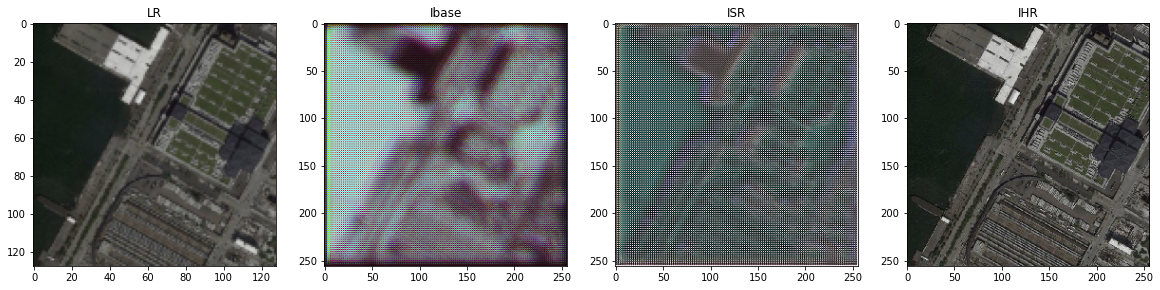

In [45]:
ix=np.random.randint(0, 1096, 1)
ILR=resized_list[ix]
IHR=src_list[ix]
Ibase=udsn(ILR)
ISR=eesn(Ibase)

plt.figure(figsize=(20, 80))

plt.subplot(1,4,1)
ILR=ILR*127.5+127.5
plt.imshow(ILR.reshape(128,128,3).astype('uint8'))
plt.title('LR')

plt.subplot(1,4,2)
Ibase1=Ibase*127.5+127.5
plt.imshow(np.array(Ibase1).reshape(256,256,3).astype('uint8'))
plt.title('Ibase')

plt.subplot(1,4,3)
ISR1=ISR*127.5+127.5
plt.imshow(np.array(ISR1).reshape(256,256,3).astype('uint8'))
plt.title('ISR')

plt.subplot(1,4,4)
plt.imshow((IHR*127.5+127.5).reshape(256,256,3).astype('uint8'))
plt.title('IHR')

In [ ]:
#vgg(Ibase)

In [ ]:
Ibase*127.5+127.5

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[ 43.096985, 240.82367 ,  68.11273 ],
         [ 64.498566, 157.59154 ,  68.879944],
         [ 43.704163, 243.71362 ,  68.61665 ],
         ...,
         [ 43.68229 , 159.5198  ,  68.12497 ],
         [ 60.614822, 159.05173 ,  70.000854],
         [ 43.79117 , 158.84502 ,  68.43585 ]],

        [[ 52.246475, 156.72928 ,  67.9131  ],
         [ 45.351967, 152.76253 ,  68.15086 ],
         [ 43.795006, 150.24336 ,  68.247116],
         ...,
         [ 43.61476 , 153.74013 ,  68.884605],
         [ 43.44461 , 157.82523 ,  76.94539 ],
         [ 43.658203, 158.76628 ,  68.79199 ]],

        [[ 43.21006 , 153.83261 ,  68.86967 ],
         [ 83.22001 , 146.8559  ,  95.35884 ],
         [ 47.50894 , 164.7958  ,  67.5312  ],
         ...,
         [ 43.527153, 181.565   ,  67.448494],
         [ 70.19046 , 154.87796 ,  68.41407 ],
         [ 43.758713, 195.21875 ,  68.29199 ]],

        ...,

        [[ 62.392212, 146.92125 , 

In [ ]:
ISR1

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[ 75.21127 , 104.28233 ,  79.98985 ],
         [104.62926 , 118.582726, 106.52219 ],
         [ 62.293198,  89.61565 ,  66.65242 ],
         ...,
         [103.40812 , 121.027435, 108.53429 ],
         [ 93.65428 , 108.36419 ,  96.345795],
         [111.57033 , 129.01959 , 116.74997 ]],

        [[104.01282 , 119.801895, 107.72397 ],
         [ 92.76088 , 108.870255,  97.53548 ],
         [ 88.668076, 104.501396,  93.64324 ],
         ...,
         [ 88.39986 , 104.79939 ,  93.49632 ],
         [ 80.67194 ,  97.35941 ,  86.83743 ],
         [100.803154, 118.28725 , 106.02435 ]],

        [[102.576675, 119.35125 , 107.894585],
         [ 75.57559 ,  84.49844 ,  78.537704],
         [ 84.28573 , 101.62033 ,  88.52071 ],
         ...,
         [ 81.26651 , 101.63597 ,  86.027794],
         [ 84.245316,  96.565796,  85.24311 ],
         [ 87.17482 , 110.03729 ,  92.1383  ]],

        ...,

        [[102.1902  , 114.77009 , 

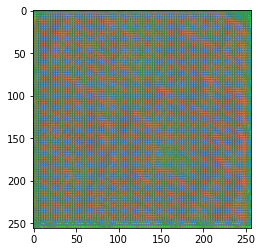

In [ ]:
plt.imshow(np.array(Ibase*127.5+127.5).reshape(256,256,3).astype('uint8'))

In [ ]:
Ibase.shape

TensorShape([1, 256, 256, 3])